# What Areas Should the Agency Focus On?

The goal of this exercise is to do explore the data to find the answer to the Question 2 problem statement:

### Should the Department of Housing Preservation and Development of New York City focus on any particular set of boroughs, ZIP codes, or street (where the complaints are severe) for the specific type of complaints you identified in response to Question 1?

In this exercise, you will use 311 Dataset to determine whether to focus on any particular borough, ZIP code, or street (where the complaints are severe) for the specific Complaint Type you decided to focus at the end of the last exercise.

Add your answer to this question along with code and comments in a separate notebook. Upload the notebook in the subsection called "Question 2 - Should the Department of Housing Preservation and Development of New York City focus on any particular set of Boroughs or ZIP Code or Streets (where the complaints are severe) for the specific type of Complaints you identified in response to Question 1"  in the section "Submit your work and Review your Peer's work" in the module "Submit Your Work and Grade Your Peers".

---


In [22]:
%%capture

!pip install pandas
!pip install sklearn
!pip install folium

In [23]:
import pandas as pd
import numpy as np

In [24]:
NY_311 = pd.read_csv("fhrw-4uyv.csv", parse_dates=['created_date', "closed_date"], infer_datetime_format=True)

## Create a subset, containing only heat related problems

In [25]:
HEAT_RELATED = NY_311[ (NY_311.complaint_type == "HEATING") | (NY_311.complaint_type ==  "HEAT/HOT WATER") ]

In [26]:
gps_data_for_heatmap = HEAT_RELATED[['latitude', 'longitude']].dropna()

## Create clusters of GPS coordinates. Each cluster center represents a local epicenter of complains

Make use of `MiniBatchKMeans()` as this is the fast version of regular KMeans

For this and upcoming folium plots - use 
https://nbviewer.jupyter.org/

In [27]:
%%time 
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=1500,random_state=0,batch_size=300)
kmeans = kmeans.fit(gps_data_for_heatmap)
kmeans.cluster_centers_

unique, counts = np.unique(kmeans.predict(gps_data_for_heatmap), return_counts=True, )

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:1561: RuntimeWarning: init_size=900 should be larger than k=1500. Setting it to 3*k
  init_size=init_size)
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:1561: RuntimeWarning: init_size=900 should be larger than k=1500. Setting it to 3*k
  init_size=init_size)
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:1561: RuntimeWarning: init_size=900 should be larger than k=1500. Setting it to 3*k
  init_size=init_size)


CPU times: user 2min 50s, sys: 2min 29s, total: 5min 19s
Wall time: 1min 24s


## Create a DataFrame, containing the centers - to later plot with folium

After KMeans - we are now able to plot *all* datapoints, as we only plot the 1500 centers (with counts, as some centers represent more points).

In [28]:
centers = pd.DataFrame( kmeans.cluster_centers_[unique], columns=["lat", "long"])
centers["count"] = counts

In [29]:
import folium

new_york = (40.78, -73.89)

#lat_lng_list = list( zip( list(madrid_with_price.lat), list(madrid_with_price.lng) ) )
#house_density = [ (lat,lng,0.3) for (lat,lng) in lat_lng_list ]


from folium.plugins import HeatMap

map_with_houses = folium.Map(new_york, tiles='stamentoner', zoom_start=11)

HeatMap(centers[['lat', 'long', 'count']].dropna(), radius=3, blur=2).add_to(map_with_houses)
map_with_houses

In [30]:
import folium
from folium.plugins import FastMarkerCluster

new_york = (40.78, -73.89)

new_york_map = folium.Map(new_york, zoom_start=11)

listed_points = HEAT_RELATED[["latitude", "longitude"]].dropna().sample(10000).values.tolist()

new_york_map.add_child(FastMarkerCluster(listed_points))
new_york_map

## COMMENTS

A heatmap of heat-related problem locations clearly shows areas where the problems most arise.
Futher analysis will show which zipcodes are related with the dense area.
Visual Inspecition already hints which area to focus on

## Create a top list of postal codes, ranked where 1st postal code contains most complains

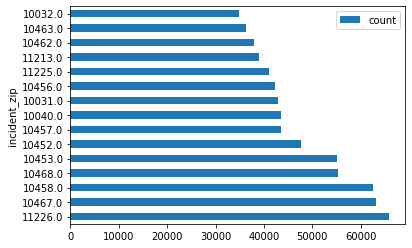

In [31]:
%matplotlib inline

top_postal_codes = HEAT_RELATED.groupby("incident_zip").agg({"incident_zip" : ['count']})

top_postal = top_postal_codes["incident_zip"].sort_values("count", ascending=False).head(20)
top_postal.head(15).plot(kind='barh')

## COMMENTS

- Upper graph shows ZipCode's to focus on.
- I will create a new map, where I overlay the top 20 postalcodes to check if heatmap and postal codes agree

## Extract GEOJson for top postal codes, to later plot on map

In [32]:
import json

GEOJSON_TOP = []

with open('nyc-zip-code-tabulation-areas-polygons.geojson') as json_file:
    data = json.load(json_file)

    for record in data["features"]:
        if int(record["properties"]["postalCode"]) in top_postal.index:
            GEOJSON_TOP.append(record)

In [33]:
zip_json = None

with open('nyc-zip-code-tabulation-areas-polygons.geojson') as json_file:
    zip_json = json.load(json_file)

## Plotting contours of top-10 postal codes over heatmap, shows postalcodes and KMeans analysis agree on top areas

In [34]:
import folium
from folium.plugins import HeatMap

new_york = (40.78, -73.89)

map_with_houses = folium.Map(new_york, tiles='stamentoner', zoom_start=11)
for record in GEOJSON_TOP:
    folium.GeoJson(record).add_to(map_with_houses)
HeatMap(centers[['lat', 'long', 'count']].dropna(), radius=3, blur=2, ).add_to(map_with_houses)

map_with_houses

## A Folium choropleth plot

In [35]:
import folium
from folium.plugins import HeatMap

new_york = (40.78, -73.89)

zip_codes_count = top_postal_codes.incident_zip
zip_codes_count = zip_codes_count.assign(zipcode_string=zip_codes_count.index.astype(int))
zip_codes_count.zipcode_string = zip_codes_count.zipcode_string.apply(str)

map_with_houses = folium.Map(new_york,  zoom_start=10)
map_with_houses.choropleth(
    geo_data=zip_json,
    data=zip_codes_count,
    columns=['zipcode_string','count'],
    key_on='feature.properties.postalCode',
    fill_color='YlOrRd',
    fill_opacity=0.7, 
    line_opacity=0.2,
    #threshold_scale=[0,400000,500000,550000,600000,650000,700000,100000000000],
    legend_name='Number of complaints',
)
#folium.GeoJson(zip_json).add_to(map_with_houses)
#HeatMap(centers[['lat', 'long', 'count']].dropna(), radius=3, blur=2, ).add_to(map_with_houses)

map_with_houses

/usr/local/lib/python3.6/dist-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## COMMENTS

Indeed, Zip Code analysis and heatmap of problems agree

## Repeat Count & Folium map overlay with top Boroughs

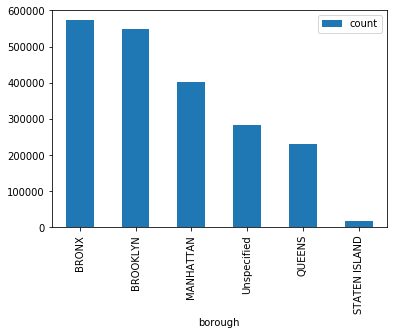

In [36]:
borough_count = HEAT_RELATED.groupby("borough").agg({"borough" : ['count']})

top_borough = borough_count["borough"].sort_values("count", ascending=False).plot(kind='bar')

In [37]:
Boroughs = {"type":"FeatureCollection","features":[
	{"type":"Feature","id":"USA-NY-BRONX","properties":{"name":"Bronx","state":"NY"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-73.9189,40.9108],[-73.9189,40.9163],[-73.7820,40.8834],[-73.7820,40.8396],[-73.8148,40.8341],[-73.7874,40.8013],[-73.8148,40.8067],[-73.9134,40.7958],[-73.9244,40.8779],[-73.9353,40.8834]]]]}},
	{"type":"Feature","id":"USA-NY-KINGS","properties":{"name":"Kings","state":"NY"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-73.9517,40.7410],[-73.8970,40.6808],[-73.8696,40.6972],[-73.8313,40.6315],[-73.8477,40.5877],[-73.9408,40.5658],[-74.0120,40.5767],[-74.0449,40.6260],[-74.0229,40.6808],[-73.9627,40.7355]]]]}},
	{"type":"Feature","id":"USA-NY-NY","properties":{"name":"New York","state":"NY"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-73.9244,40.8779],[-73.9134,40.7958],[-73.9627,40.7355],[-74.0229,40.6808],[-74.0229,40.7082],[-73.9846,40.7958],[-73.9353,40.8834]]]]}},
	{"type":"Feature","id":"USA-NY-QUEENS","properties":{"name":"Queens","state":"NY"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-73.8148,40.8067],[-73.7874,40.8013],[-73.7655,40.8013],[-73.6998,40.7410],[-73.7272,40.7191],[-73.7272,40.6534],[-73.7655,40.6260],[-73.7546,40.5877],[-73.9353,40.5438],[-73.9408,40.5658],[-73.8477,40.5877],[-73.8313,40.6315],[-73.8696,40.6972],[-73.8970,40.6808],[-73.9517,40.7410],[-73.9627,40.7355],[-73.9134,40.7958]]]]}},
	{"type":"Feature","id":"USA-NY-RICHMOND","properties":{"name":"Richmond","state":"NY"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-74.0887,40.6479],[-74.0668,40.5822],[-74.2475,40.4946],[-74.1873,40.6424]]]]}}	
]}

In [38]:
top_borough_names = ["USA-NY-BRONX", "USA-NY-KINGS", "USA-NY-NY"]
top_boroughs = {"type":"FeatureCollection","features":[ b for b in Boroughs["features"] if b["id"] in top_borough_names]}

In [39]:
import folium
from folium.plugins import HeatMap

new_york = (40.78, -73.89)

map_with_houses = folium.Map(new_york, tiles='stamentoner', zoom_start=11)
folium.GeoJson(top_boroughs).add_to(map_with_houses)
HeatMap(centers[['lat', 'long', 'count']].dropna(), radius=3, blur=2, ).add_to(map_with_houses)

map_with_houses

## COMMENTS

- Borough level seems to general to give focus. It agrees with previous analysis.
- Borough not suitable as focus area

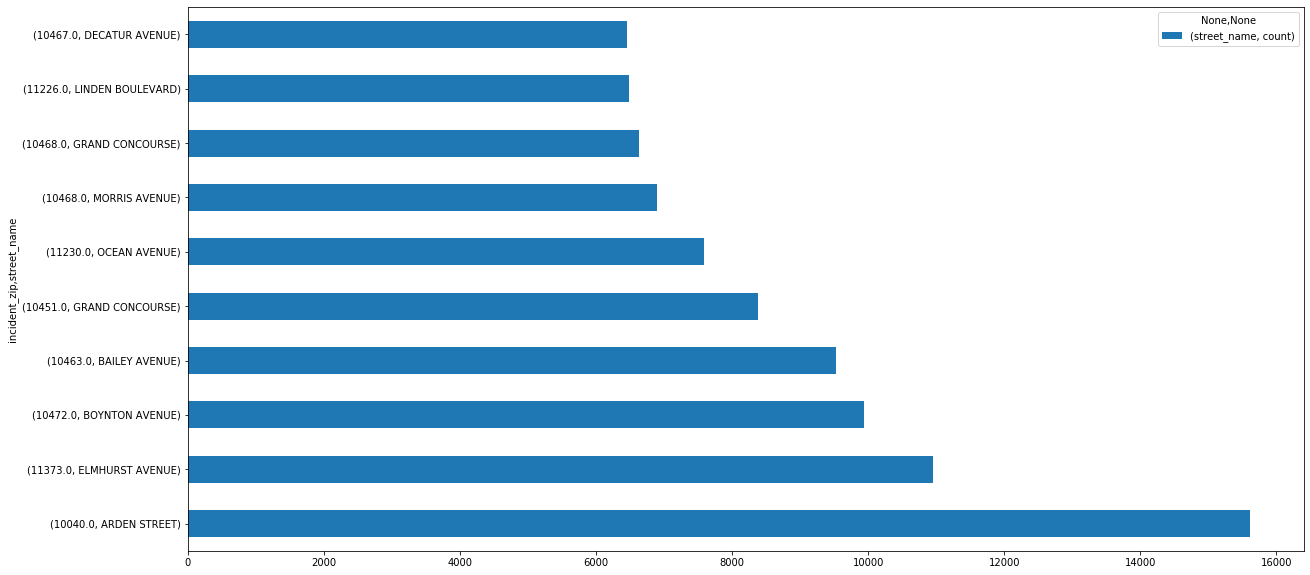

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

street_names_count = HEAT_RELATED.groupby(['incident_zip', "street_name"]).agg({"street_name" : ['count']})

top_streets = street_names_count.sort_values(("street_name","count"), ascending=False).head(10)
top_streets.head(20).plot(kind="barh", ax=ax)


In [41]:
top_postal.head(10)

count
incident_zip       
11226.0       65925
10467.0       63163
10458.0       62551
10468.0       55349
10453.0       55152
10452.0       47746
10457.0       43605
10040.0       43452
10031.0       42986
10456.0       42265

## COMMENTS

- Heatmap, ZipCodes, and Street Level all shows different levels on which to focus on
- ZipCodes is a nice level to give an effective level of granuality to focus on
- The upper 10 PostalCodes would be my recommendation to focus on